# Chuẩn bị



1. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

2. Di chuyển file này vào thư mục chess-bot

## Import thư viện cần thiết

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import chess
import time
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.static_evaluation import evaluate_board
from bot import ChessBot


## Lấy tập dữ liệu

In [ ]:
df = pd.read_csv('chessData.csv')
df.head()
test_fens = df.sample(n=50, random_state=10)['FEN'].to_list()
#nên thay đổi test_fens mỗi thế hệhệ

FileNotFoundError: [Errno 2] No such file or directory: 'chessData.csv'

## Visualization

In [ ]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [ ]:
showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

NameError: name 'df' is not defined

# 1. Initialization

In [ ]:
def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.
    
    - The first 5 parameters (evaluation weights) are floating-point numbers.
    - The remaining parameters (piece values, penalties, multipliers) are integers.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    # Define bounds for each gene type
    bounds = np.array([
    [150, 550],           # square_controlled_by_opponent_pawn_penalty (350 ± 200)
    [0, 200],            # captured_piece_value_multiplier (100 ± 100)

    [25, 40]             # max_killer_move_ply(32 ± 7)
    [90_000, 110_000],   # hash_move_score (100k ± 10%)
    [6_000, 10_000],     # winning_capture_bias (8K ± 2K)
    [5_000, 7_000],      # promote_bias (6K ± 1K)
    [3_000, 5_000],      # killer_bias (4K ± 1K)
    [1_500, 2_000]       # losing_capture_bias (2K ± 500)
    ], dtype=int)

    num_params = len(bounds)

    # Generate population matrix
    population = np.zeros((size, num_params))

    for i in range(num_params):
        low, high = bounds[i]
        population[:, i] = np.random.randint(low, high + 1, size=size)
    return population

# Generate population with 200 individuals
population = initialize_population(20)

# Print first 3 individuals for verification
print(population[:3])


[[ 2.52736650e+00 -2.49313119e+00  2.01472052e+00  4.73118676e+00
   2.50901371e+00  1.03000000e+02  3.09000000e+02  3.43000000e+02
   4.54000000e+02  8.63000000e+02  9.13100000e+03  2.50000000e+01
   2.90000000e+01  2.70000000e+01  1.00000000e+00  8.00000000e+00]
 [ 1.16158555e+00  4.12589023e+00 -4.60958673e+00  6.22087632e-01
  -1.09852822e+00  1.19000000e+02  3.08000000e+02  3.06000000e+02
   5.27000000e+02  8.54000000e+02  9.57600000e+03  1.40000000e+01
   1.30000000e+01  1.00000000e+00  1.00000000e+01  2.00000000e+00]
 [ 4.46153452e+00 -3.06788714e+00  3.27573797e+00  5.59331711e-01
   4.80247171e+00  1.19000000e+02  2.74000000e+02  3.33000000e+02
   5.16000000e+02  9.77000000e+02  1.06310000e+04  1.10000000e+01
   1.70000000e+01  2.00000000e+00  6.00000000e+00  1.30000000e+01]]


# Fitness function

In [ ]:
def fitness_function(weights: List[float]) -> float:
    by_time = False # if false fitness by depth
    time_limit = 5
    nnue_order = False   
    #these var should outer the block
    if nnue_order:
        chess_bot = ChessBot(use_nnue=True)
    else:
        chess_bot = ChessBot()    
    total_fitness = 0
    chess_bot.searcher.move_orderer.update_weights(weights)
    if by_time:
        start = time.perf_counter()
        for fen in test_fens:
            chess_bot.set_position(fen)
            chess_bot.get_best_move(4) # nói thật chỗ này t chưa chắc, tốt nhất là chạy ở 5,6,7 + chưa chắc dùng đúng hàm kk
        end = time.perf_counter()
        total_fitness= -(end - start) * 1000 #fitness = âm tổng thời gian search;
    else:
        pass# fitness by depth        
    return total_fitness / len(test_fens) # thời gian càng ít càng tốttốt

# Selection

In [ ]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [ ]:
def crossover_mixed(parent1, parent2, alpha=0.4, crossover_rate=0.5):
    """
    Perform crossover with an adaptive probability.

    Args:
        parent1 (np.array): First parent.
        parent2 (np.array): Second parent.
        alpha (float): Alpha parameter for BLX-α crossover (for floats).
        crossover_rate (float): Probability of crossover.

    Returns:
        np.array: Child with mixed-type values.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    child = np.zeros_like(p1)

    for i in range(len(p1)):
        """if np.random.rand() < crossover_rate:  # Perform crossover with given probability
            if i < 5:  # Floating-point genes (evaluation weights)
                min_val, max_val = min(p1[i], p2[i]), max(p1[i], p2[i])
                range_val = max_val - min_val
                child[i] = min_val - alpha * range_val + np.random.rand() * (1 + 2 * alpha) * range_val
            else:  # Integer genes
                child[i] = np.random.choice([p1[i], p2[i]])
        else:"""
        child[i] = np.random.choice([p1[i], p2[i]])  # Inherit directly from a parent
    return child


# Mutation

In [ ]:
def mutate_mixed(individual, mutation_rate=0.3, mutation_strength=0.1):
    """
    Apply adaptive mutation to floating-point and integer genes.

    Args:
        individual (np.array): Individual's genes.
        mutation_rate (float): Probability of mutation.
        mutation_strength (float): Mutation intensity.

    Returns:
        np.array: Mutated individual.
    """
    mutated = np.copy(individual)

    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Mutation occurs with probability
            """if i < 5:  # Floating-point mutation (evaluation weights)
                mutated[i] += np.random.normal(0, mutation_strength)
            else:  # Integer mutation (piece values, penalties, multipliers)"""
            step = np.random.randint(-1, 2)  # Change by -1, 0, or +1
            mutated[i] += step

    return mutated


In [ ]:
def adaptive_mutation_rate(generation, max_generations, min_rate=0.1, max_rate=0.4):
    """
    Adaptive mutation rate: Decreases as generations progress.
    """
    return max_rate - (max_rate - min_rate) * (generation / max_generations)

In [ ]:

def adaptive_crossover_rate(generation, max_generations, min_rate=0.2, max_rate=0.7):
    """
    Adaptive crossover rate: Increases as generations progress.
    """
    return min_rate + (max_rate - min_rate) * (generation / max_generations)


# GA

In [ ]:
def genetic_algorithm(
    fitness_function,
    population_size=100,
    generations=100,
    elite_size=10,
    tournament_size=5,
    convergence_threshold=20
):
    """
    Runs an optimized Genetic Algorithm with adaptive mutation and crossover rates.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals retained.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if no improvement.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf
    no_improvement_count = 0

    for generation in range(generations):
        # Adaptive rates
        mutation_rate = adaptive_mutation_rate(generation, generations)
        crossover_rate = adaptive_crossover_rate(generation, generations)

        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])

        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Stop early if fitness has not improved
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_mixed(p1, p2, crossover_rate=crossover_rate)
            child = mutate_mixed(child, mutation_rate, mutation_strength=0.1)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}, Mutation Rate = {mutation_rate:.3f}, Crossover Rate = {crossover_rate:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -292788.993, Mutation Rate = 0.400, Crossover Rate = 0.200
Generation 2: Best Fitness = -289485.538, Mutation Rate = 0.399, Crossover Rate = 0.203
Generation 3: Best Fitness = -284491.598, Mutation Rate = 0.397, Crossover Rate = 0.205
Generation 4: Best Fitness = -284491.598, Mutation Rate = 0.396, Crossover Rate = 0.208
Generation 5: Best Fitness = -284344.418, Mutation Rate = 0.394, Crossover Rate = 0.210
Generation 6: Best Fitness = -284148.185, Mutation Rate = 0.393, Crossover Rate = 0.213
Generation 7: Best Fitness = -283855.504, Mutation Rate = 0.391, Crossover Rate = 0.215
Generation 8: Best Fitness = -283855.504, Mutation Rate = 0.390, Crossover Rate = 0.217
Generation 9: Best Fitness = -283855.504, Mutation Rate = 0.388, Crossover Rate = 0.220
Generation 10: Best Fitness = -283819.161, Mutation Rate = 0.387, Crossover Rate = 0.223
Generation 11: Best Fitness = -283776.801, Mutation Rate = 0.385, Crossover Rate = 0.225
Generation 12: Best Fitness = 

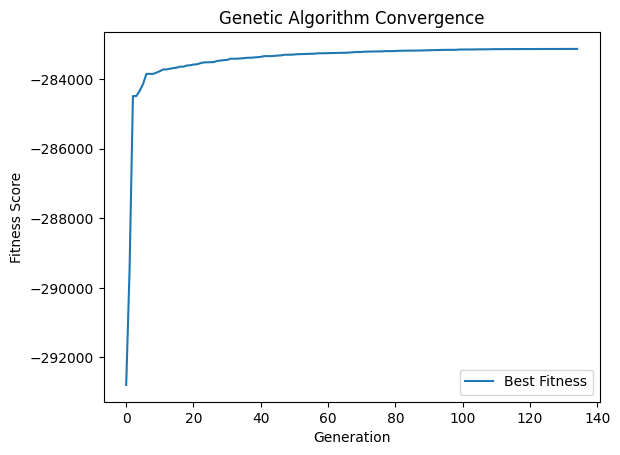

Optimized Weights: [6.16794464e-01 3.49088090e+00 1.07324170e+00 4.02419631e+00
 2.04941519e+00 1.54000000e+02 2.75000000e+02 3.46000000e+02
 4.96000000e+02 8.40000000e+02 9.75400000e+03 3.70000000e+01
 7.00000000e+00 4.00000000e+00 0.00000000e+00 5.00000000e+00]
Suggested weights fitness: -322199.5


In [ ]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=200, generations=200, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15,
                100, 300, 320, 500, 900, 10000,
                10, 10,
                20,
                5,
                10
            ]
print("Suggested weights fitness:", fitness_function(chromosomes))